**English Learning - submitted by Paarth Aggarwal**

Youtube Demo Link: https://www.youtube.com/watch?v=XUUipfrCx7s

**Purpose:** The code allows individuals from various different communities, languages, cultures, to improve their understanding of the English language. It would also help people with limited access to English education and communities from backward backgrounds to sharpen up their skill in English language without much support from educators eventually driving significant social benefits.

The user can speak in natural language in English which gets converted into the input text via speech to text model. Further, the open source model analyses the input text and comes up with the correct English.

**For example, the input text could be:** The cat don't likes to sleep on the couch, it prefers the floor where its more cooler.

The correct English version is: The cat **doesn't like** to sleep on the couch, it prefers the floor where **it's** cooler

**About the code**
- This code is inspired by the **Intel® OpenVINO™**
- Used pre-trained models from the Hugging Face Transformers library with inbuilt microphone to speech to take speech input from the user

-When the code is executed, a gradio link will appear at the bottom of the google colab which will transport the user to the gradio local host. You MUST click on the link to be transported to the gradio local host
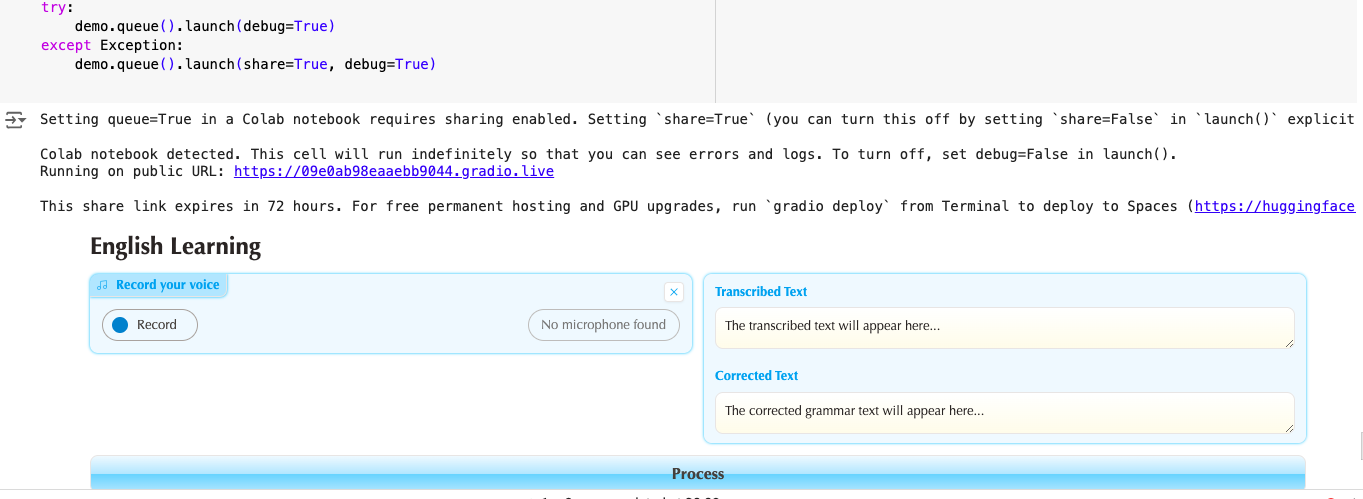
- When you first open the gradio interface, a notification will pop up, asking whether or not to allow gradio to use your microphone, click **Allow** and speak into the microphone. When you are done, click the **Stop** button
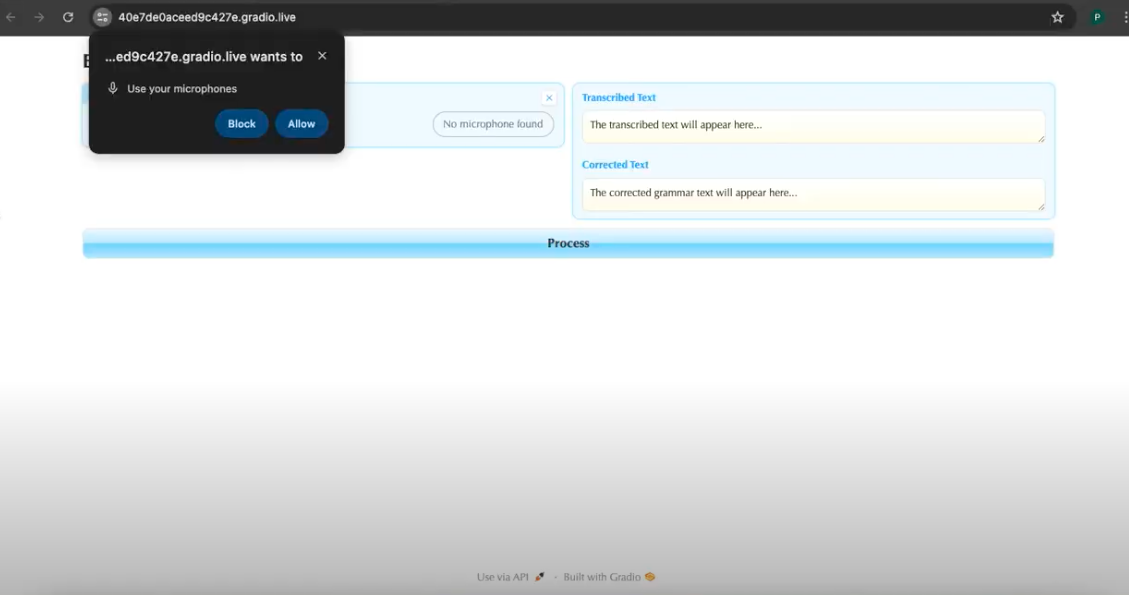
- After the **Process** button is pressed, the speech input is run through a pre-trained speech to text model and the text output is shown in a textbox
- The text is run through a pre-trained language checker model where it will detect any language errors and is then run through a pre-trained language correction model where it will correct the language errors detected by the language checker model
- The final text will be displayed in the second textbox
- To execute this code, go to **Runtime** on the top, then click, **Run all**

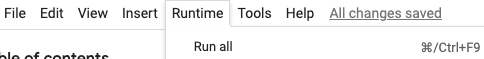

- Since the code is resource-intensive, go to the dropdown on the top-right, next to **RAM**, then click on **Change runtime type** and change the **hardware accelerator** and **runtime type** to **T4 GPU** and **Python 3** respectively



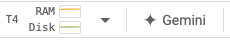






In [ ]:
#Installing all relevant modules/libraries

%pip install -q "torch>=2.1.0" "git+https://github.com/huggingface/optimum-intel.git" "openvino>=2024.0.0" onnx tqdm "gradio>=4.19" "transformers>=4.33.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "nncf>=2.9.0" datasets jiwer
!pip install pyarrow==12.0.0 pandas==1.5.3
!pip install optimum

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyarrow-12.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
Using cached pyarrow-12.0.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.9 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 17.0.0
    Uninstalling pyarrow-17.0.0:
      Successfully uninstalled pyarrow-17.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 12.0.0 which is inc

In [ ]:
#importing all models
from pathlib import Path #used to identify the path for the models
from transformers import pipeline, AutoTokenizer #used to load the model
from optimum.intel.openvino import OVModelForSeq2SeqLM, OVModelForSequenceClassification #using the OpenVino Toolkit
import numpy as np

p = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")

transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#We have 2 models for language correction: one is the language checker model (below) which checks for any English language errors
grammar_checker_model_id = "textattack/roberta-base-CoLA"
grammar_checker_dir = Path("roberta-base-cola")
grammar_checker_tokenizer = AutoTokenizer.from_pretrained(grammar_checker_model_id)
grammar_checker_model = OVModelForSequenceClassification.from_pretrained(grammar_checker_model_id, export=True, load_in_8bit=False)
grammar_checker_model.save_pretrained(grammar_checker_dir)


Framework not specified. Using pt to export the model.
Some weights of the model checkpoint at textattack/roberta-base-CoLA were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using framework PyTorch: 2.3.1+cu121
Overriding 1 configuration item(s)
	- use_cache -> False
Compiling the model to CPU ...


In [ ]:
grammar_checker_pipe = pipeline(
    "text-classification",
    model=grammar_checker_model,
    tokenizer=grammar_checker_tokenizer,
)

In [ ]:
#The 2nd model for language correction is below which corrects the language errors identified by the first model
grammar_corrector_model_id = "pszemraj/flan-t5-large-grammar-synthesis"
grammar_corrector_dir = Path("flan-t5-large-grammar-synthesis")
grammar_corrector_tokenizer = AutoTokenizer.from_pretrained(grammar_corrector_model_id)
grammar_corrector_model = OVModelForSeq2SeqLM.from_pretrained(grammar_corrector_model_id, export=True)
grammar_corrector_model.save_pretrained(grammar_corrector_dir)

Framework not specified. Using pt to export the model.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'min_length': 8, 'num_beams': 2, 'no_repeat_ngram_size': 4}
Using framework PyTorch: 2.3.1+cu121
Overriding 1 configuration item(s)
	- use_cache -> False
Using framework PyTorch: 2.3.1+cu121
Overriding 1 configuration item(s)
	- use_cache -> True
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1026: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_

In [ ]:
grammar_corrector_pipe = pipeline(
    "text2text-generation",
    model=grammar_corrector_model,
    tokenizer=grammar_corrector_tokenizer,
)

In [ ]:
import re
import transformers
from tqdm.notebook import tqdm


def split_text(text: str) -> list:

    # For large pieces of text, we plan to split (parser) the text into different sentences, the output resulting in the code returning a list for the sentences
    # Split the text into sentences using regex
    sentences = re.split(r"(?<=[^A-Z].[.?]) +(?=[A-Z])", text)

    # Initialize a list to store the sentence batches
    sentence_batches = []

    # Initialize a temporary list to store the current batch of sentences
    temp_batch = []

    # Iterate through the sentences
    for sentence in sentences:
        # Add the sentence to the temporary batch
        temp_batch.append(sentence)

        if len(temp_batch) >= 2 and len(temp_batch) <= 3 or sentence == sentences[-1]:
            sentence_batches.append(temp_batch)
            temp_batch = []

    return sentence_batches

def correct_text(
    text: str,
    checker: transformers.pipelines.Pipeline,
    corrector: transformers.pipelines.Pipeline,
    separator: str = " ",
) -> str:
    """
    Below, we are correcting the grammar in a string of text using the text-classification and text-generation pipelines
    which were defined before in the code.
  """
    # Split the text into sentence batches
    sentence_batches = split_text(text)

    # Initialize a list to store the corrected text
    corrected_text = []

    # Iterate through the sentence batches
    for batch in tqdm(sentence_batches, total=len(sentence_batches), desc="correcting text.."):
        # Join the sentences in the batch into a single string
        raw_text = " ".join(batch)

        # Check the grammar quality of the text using the text-classification pipeline
        results = checker(raw_text)

        # Only correct the text if the results of the text-classification are not LABEL_1 or are LABEL_1 with a score below 0.9
        if results[0]["label"] != "LABEL_1" or (results[0]["label"] == "LABEL_1" and results[0]["score"] < 0.9):
            # Correct the text using the text-generation pipeline
            corrected_batch = corrector(raw_text)
            corrected_text.append(corrected_batch[0]["generated_text"])
        else:
            corrected_text.append(raw_text)

    # Join the corrected text into a single string
    corrected_text = separator.join(corrected_text)

    return corrected_text

In [ ]:
# default_text = (
#     "Most of the course is about semantic or  content of language but there are also interesting"
#     " topics to be learned from the servicefeatures except statistics in characters in documents.At"
#     " this point, He introduces herself as his native English speaker and goes on to say that if"
#     " you contine to work on social scnce"
# )

# corrected_text = correct_text(default_text, grammar_checker_pipe, grammar_corrector_pipe)

In [ ]:
# print(f"input text:     {default_text}\n")
# print(f"generated text: {corrected_text}")

In [ ]:
from transformers import pipeline
import gradio as gr
import numpy as np

# Load the transcription and grammar correction models
transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")


theme = gr.themes.Glass(
    primary_hue="sky",
    secondary_hue="amber",
)

def transcribe_and_correct(audio):
    # Transcribe the audio
    sr, y = audio
    y = y.astype(np.float32)
    y /= np.max(np.abs(y))
    transcription = transcriber({"sampling_rate": sr, "raw": y})["text"]

    # Correct the transcribed text
    corrected_text = correct(transcription, quantized=False)
    return transcription, corrected_text

def correct(text, quantized):
     grammar_corrector = grammar_corrector_pipe
     corrected_text = correct_text(text, grammar_checker_pipe, grammar_corrector)
     return corrected_text

with gr.Blocks(theme=theme) as demo:
    gr.Markdown("# English Learning")

    with gr.Row():
        with gr.Column():
            audio_input = gr.Audio(sources="microphone", label="Record your voice")
        with gr.Column():
            transcribed_text = gr.Textbox(label="Transcribed Text", placeholder="The transcribed text will appear here...")
            corrected_text = gr.Textbox(label="Corrected Text", placeholder="The corrected grammar text will appear here...")

    with gr.Row():
        gr.Button("Process").click(
            transcribe_and_correct,
            inputs=[audio_input],
            outputs=[transcribed_text, corrected_text]
        )

# Launching Gradio
try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://09e0ab98eaaebb9044.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://09e0ab98eaaebb9044.gradio.live
